In [8]:
import sys
# 1つ上の階層 (project/) を sys.path に追加
sys.path.append("..")

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
from tiny_llm.gpt_model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "emb_dim": 768,
    "context_length": 256,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_attn": 0.1,
    "drop_rate_shortcut": 0.1,
    "drop_rate_emb": 0.1,
    "qkv_bias": False,
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [15]:
import tiktoken
from tiny_llm.utils import text_to_token_ids, generate_text_simple, token_ids_to_text

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [16]:
inputs = torch.tensor([[16833,3626,6100],[40,1107,588]])
targets = torch.tensor([[3626,6100,345], [1107,588,11311]])

In [17]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [18]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [19]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Predicted batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Predicted batch 1:  Armed heNetflix


In [20]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text1 :", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text2 :", target_probas_2)


Text1 : tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text2 : tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [21]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [22]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [23]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [84]:
print("Ligits shape:", logits.shape)
print("Target shape:", targets.shape)

Ligits shape: torch.Size([2, 3, 50257])
Target shape: torch.Size([2, 3])


In [24]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattend logits:", logits_flat.shape)
print("Flattend targets:", targets_flat.shape)

Flattend logits: torch.Size([6, 50257])
Flattend targets: torch.Size([6])


In [25]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [27]:
file_path = "../the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [28]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [31]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [32]:
from tiny_llm.data_loader import create_dateloader_v1

torch.manual_seed(123)

train_loader = create_dateloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dateloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0,
)

In [91]:
print("Train loader:")
for x, y in train_loader:
    print("x:", x.shape, "y:", y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print("x:", x.shape, "y:", y.shape)

Train loader:
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])
x: torch.Size([2, 256]) y: torch.Size([2, 256])

Validation loader:
x: torch.Size([2, 256]) y: torch.Size([2, 256])


In [33]:
from tiny_llm.utils import calc_loss_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad(): # まだ訓練していないため、効率化のために勾配の追跡を無効化
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Train loss:", train_loss)
print("Validation loss:", val_loss)

Train loss: 10.98758347829183
Validation loss: 10.98110580444336


In [93]:
from tiny_llm.utils import train_model_simple

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), # parameters() メソッドでモデルのパラメータを取得
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)



Ep 1 (Step 000000): Train loss: 9.781, Val loss: 9.933
Ep 1 (Step 000005): Train loss: 8.111, Val loss: 8.339
Every effort moves you,,,,,,,,,,,,.
Ep 2 (Step 000010): Train loss: 6.661, Val loss: 7.048
Ep 2 (Step 000015): Train loss: 5.961, Val loss: 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss: 5.726, Val loss: 6.600
Ep 3 (Step 000025): Train loss: 5.201, Val loss: 6.348
Every effort moves you, and I had been.
Ep 4 (Step 000030): Train loss: 4.417, Val loss: 6.278
Ep 4 (Step 000035): Train loss: 4.069, Val loss: 6.226
Every effort moves you know the"I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss: 3.732, Val loss: 6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, and in the"Oh, and he said, and down the room, and in
Ep 6 (Step 000045

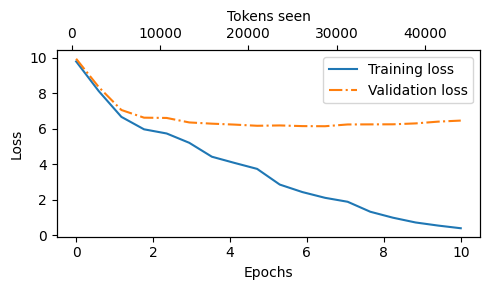

In [94]:
from tiny_llm.utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [95]:
model.to("cpu")
model.eval() # 評価モードに切り替えて、ドロップアウトなどのランダムな要素をオフにする

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


In [96]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [97]:
inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [98]:
probas = torch.softmax(next_token_logits, dim=-1)
next_token_ids = torch.argmax(probas).item()
print(inverse_vocab[next_token_ids])

forward


In [99]:
torch.manual_seed(123)
next_token_ids = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_ids])

forward


In [100]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):        
        print(f"{inverse_vocab[i]}: {freq.item()}")
    
print_sampled_tokens(probas)    

closer: 73
every: 0
effort: 0
forward: 582
inches: 2
moves: 0
pizza: 0
toward: 343


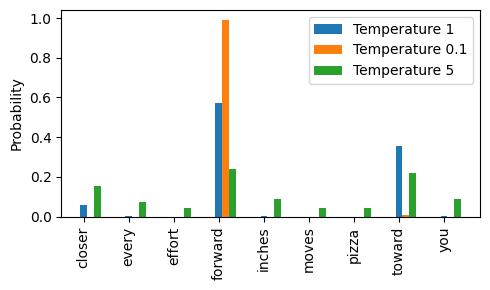

In [101]:
from tiny_llm.utils import softmax_with_temperature
import matplotlib.pyplot as plt

templatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in templatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(templatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)    
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


In [102]:
for i, T in enumerate(templatures):
    print(f"Temperature {T}:")
    print_sampled_tokens(scaled_probas[i])
    print("\n")

Temperature 1:
closer: 73
every: 0
effort: 0
forward: 582
inches: 2
moves: 0
pizza: 0
toward: 343


Temperature 0.1:
closer: 0
every: 0
effort: 0
forward: 985
inches: 0
moves: 0
pizza: 0
toward: 15


Temperature 5:
closer: 165
every: 75
effort: 42
forward: 239
inches: 71
moves: 46
pizza: 32
toward: 227
you: 103




In [103]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, k=top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)


Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [104]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # 上位3つのロジットよりも小さいロジットを特定
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [105]:
top_k_probas = torch.softmax(new_logits, dim=0)
print(top_k_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [36]:
from tiny_llm.utils import generate

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=1.4,
    top_k=25,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves youEveryiliaralso stabbed OrleansAllowsean 52anche crime winter unbeaten quoteembedreportprint earning


In [107]:
torch.save(model.state_dict(), "model.pth")

In [108]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [109]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),    
    },
    "model_and_optimizer.pth"
)

In [110]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [111]:
num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss: 0.275, Val loss: 6.541
Ep 1 (Step 000005): Train loss: 0.205, Val loss: 6.571
Every effort moves you?""Yes--quite insensible to the irony. She wanted him vindicated--and by me!"He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I


In [113]:
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch05/01_main-chapter-code/gpt_download.py"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x3008c8550>)

In [1]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="gpt2",
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 117kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 480kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 74.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [20:33<00:00, 404kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.26MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 716kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 345kiB/s] 


In [2]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [3]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [4]:
model_configs = {
    "gpt2-small(124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium(355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large(774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl(1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [11]:
model_name = "gpt2-small(124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})  # GPT-2のコンテキスト長は1024トークン
NEW_CONFIG.update({"qkv_bias": True}) 

In [12]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [35]:
from tiny_llm.utils import load_weights_into_gpt

load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [38]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5   
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




In [40]:
from tiny_llm.utils import calc_loss_loader
from tiny_llm.data_loader import create_dateloader_v1

file_path = "../the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dateloader_v1(
    train_data,
    batch_size=2,
    max_length=NEW_CONFIG["context_length"],
    stride=NEW_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dateloader_v1(
    val_data,
    batch_size=2,
    max_length=NEW_CONFIG["context_length"],
    stride=NEW_CONFIG["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0,
)

train_loss = calc_loss_loader(train_loader, gpt, device)
print("Training loss:", train_loss)

val_loss = calc_loss_loader(val_loader, gpt, device)
print("Validation loss:", val_loss)

Training loss: 3.784622073173523
Validation loss: nan
